In [ ]:
! pip install requests
! pip install pandas

# IMPORT LIBRARIES

In [ ]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from google.colab import files


# LOADING DATA

In [ ]:
# URL file XML
url = 'https://data.bmkg.go.id/DataMKG/MEWS/DigitalForecast/DigitalForecast-Indonesia.xml'

# Headers to mimic a web browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Mengambil data XML dengan headers
response = requests.get(url, headers=headers)

# Periksa apakah respons sukses
if response.status_code == 200:
    response_content = response.content

    try:
        # Memparsing data XML
        root = ET.fromstring(response_content)

        # Inisialisasi list untuk menyimpan data
        data = []

        # Mengekstraksi data tertentu (contoh)
        for area in root.findall(".//area"):
            area_name = area.get('description')
            area_latitude = area.get('latitude')
            area_longitude = area.get('longitude')
            area_coordinate = area.get('coordinate')
            area_domain = area.get('domain')
            for parameter in area.findall(".//parameter"):
                parameter_name = parameter.get('id')
                for timerange in parameter.findall(".//timerange"):
                    datetime = timerange.get('datetime')
                    for value in timerange.findall('value'):
                        data.append([area_name, area_latitude, area_longitude, area_coordinate, area_domain, parameter_name, datetime, value.text])

        # Membuat DataFrame dari data
        df = pd.DataFrame(data, columns=['Kota', 'Latitude', 'Longitude', 'Coordinate', 'Provinsi', 'Parameter', 'Waktu', 'Nilai'])

        # Konversi kolom 'Waktu' ke format datetime
        df['Waktu'] = pd.to_datetime(df['Waktu'], format='%Y%m%d%H%M%S')

        # Melakukan pivoting DataFrame
        df_pivot = df.pivot_table(index=['Kota', 'Latitude', 'Longitude', 'Coordinate', 'Provinsi', 'Waktu'],
                                  columns='Parameter', values='Nilai', aggfunc='first').reset_index()

        # Membersihkan nama kolom
        df_pivot.columns.name = None

        # Mapping kode cuaca
        weather_code_mapping = {
            '0': 'Clear Skies',
            '1': 'Partly Cloudy',
            '2': 'Partly Cloudy',
            '3': 'Mostly Cloudy',
            '4': 'Overcast',
            '5': 'Haze',
            '10': 'Smoke',
            '45': 'Fog',
            '60': 'Light Rain',
            '61': 'Rain',
            '63': 'Heavy Rain',
            '80': 'Isolated Shower',
            '95': 'Severe Thunderstorm',
            '97': 'Severe Thunderstorm'
        }

        df_pivot['weather'] = df_pivot['weather'].map(weather_code_mapping)

        # Menghapus kolom 'wd' jika ada karena isinya null semua
        if 'wd' in df_pivot.columns:
            df_pivot = df_pivot.drop(columns=['wd'])

        # Menghapus baris dengan nilai null pada kolom 'humax', 'humin', 'tmax', dan 'tmin'
        df_cleaned = df_pivot.dropna(subset=['humax', 'humin', 'tmax', 'tmin'])

        # Menampilkan DataFrame yang telah diproses
        print(df_cleaned)

        # Simpan ke file CSV untuk memudahkan visualisasi selanjutnya
        df_cleaned.to_csv('data_bmkg_processed.csv', index=False)

        # Download csv
        files.download('data_bmkg_processed.csv')

    except ET.ParseError as e:
        print(f"Error parsing XML: {e}")
else:
    print(f"Failed to retrieve data: HTTP {response.status_code}")


           Kota  Latitude   Longitude           Coordinate       Provinsi  \
2         Ambon  -3.67265   128.23381   128.23381 -3.67265         Maluku   
6         Ambon  -3.67265   128.23381   128.23381 -3.67265         Maluku   
10        Ambon  -3.67265   128.23381   128.23381 -3.67265         Maluku   
14   Banda Aceh   5.54491    95.34312     95.34312 5.54491           Aceh   
18   Banda Aceh   5.54491    95.34312     95.34312 5.54491           Aceh   
..          ...       ...         ...                  ...            ...   
378     Ternate  0.833215  127.365532  127.365532 0.833215   Maluku Utara   
382     Ternate  0.833215  127.365532  127.365532 0.833215   Maluku Utara   
386  Yogyakarta  -7.80279   110.37625   110.37625 -7.80279  DI Yogyakarta   
390  Yogyakarta  -7.80279   110.37625   110.37625 -7.80279  DI Yogyakarta   
394  Yogyakarta  -7.80279   110.37625   110.37625 -7.80279  DI Yogyakarta   

                  Waktu  hu humax humin   t tmax tmin        weather  ws  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# DATA PREPROCESSING

In [ ]:
# Menghapus baris dengan nilai null pada kolom 'humax', 'humin', 'tmax', dan 'tmin'
df_cleaned = df_pivot.dropna(subset=['humax', 'humin', 'tmax', 'tmin'])

# Menggabungkan nilai-nilai yang relevan untuk clustering
df_cleaned['average_humidity'] = (df_cleaned['humax'].astype(float) + df_cleaned['humin'].astype(float)) / 2
df_cleaned['average_temperature'] = (df_cleaned['tmax'].astype(float) + df_cleaned['tmin'].astype(float)) / 2

# Hanya gunakan kolom yang relevan untuk clustering
df_clustering = df_cleaned[['average_humidity', 'average_temperature']].dropna()

# Normalisasi data
scaler = StandardScaler()
df_clustering_scaled = scaler.fit_transform(df_clustering)

<ipython-input-16-8b7ac782c498>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['average_humidity'] = (df_cleaned['humax'].astype(float) + df_cleaned['humin'].astype(float)) / 2
<ipython-input-16-8b7ac782c498>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['average_temperature'] = (df_cleaned['tmax'].astype(float) + df_cleaned['tmin'].astype(float)) / 2


# K-MEANS CLUSTERING

In [ ]:
# Model K-Means
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_clustering_scaled)

# Menambahkan label cluster ke DataFrame
df_cleaned['Cluster'] = kmeans.labels_

# Menampilkan hasil clustering
unique_clusters = df_cleaned['Cluster'].unique()
print(f"Unique Clusters: {unique_clusters}")


Unique Clusters: [1 0 2]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-17-9e42c2882680>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Cluster'] = kmeans.labels_


In [ ]:
# Menghitung statistik deskriptif untuk setiap kluster
cluster_stats = df_cleaned.groupby('Cluster')[['average_humidity', 'average_temperature']].describe()

# Menampilkan statistik deskriptif untuk setiap kluster
print(cluster_stats)

        average_humidity                                                    \
                   count       mean       std   min     25%    50%     75%   
Cluster                                                                      
0                   41.0  74.207317  3.465861  67.5  72.500  75.00  77.500   
1                   50.0  83.150000  2.979950  77.5  80.000  82.50  85.000   
2                    8.0  76.562500  3.519715  72.5  74.375  76.25  78.125   

              average_temperature                                          \
          max               count       mean       std   min   25%    50%   
Cluster                                                                     
0        80.0                41.0  28.414634  0.511156  27.0  28.0  28.50   
1        92.5                50.0  27.290000  0.655355  25.5  27.0  27.50   
2        82.5                 8.0  25.062500  1.545443  21.5  25.0  25.25   

                       
            75%   max  
Cluster             

# VISUALIZATION

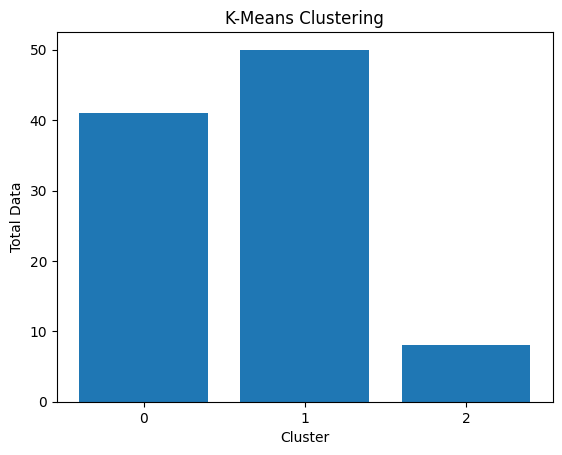

In [ ]:
 # Visualisasi Hasil K-Means menggunakan Bar Chart
plt.hist(df_cleaned['Cluster'], bins=range(4), align='left', rwidth=0.8)
plt.xlabel('Cluster')
plt.ylabel('Total Data')
plt.title('K-Means Clustering')
plt.xticks(range(3))
plt.show()
